Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [2]:
run ../util/setupConsole_su

In [3]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak/Maize_yield_1970_2013'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [4]:
# files = glob.glob('%s/cmip6_output/*.nc'%dirProj)
# for f in files:
#     os.rename(f,'%s.nc'%f[0:-4]) 

In [5]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [6]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [7]:
region = 'us'

if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
else:
    latRange = [20, 55]
    lonRange = [220, 300]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_us = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_us

In [8]:
cmip6_tasmax_max = xr.Dataset()
cmip6_tasmax_mean = xr.Dataset()

cmip6_models_tasmax = []

for m, model in enumerate(cmip6_models):
    
    if not os.path.isfile('cmip6_output/cmip6_tasmax_max_global_%s.nc'%cmip6_models[m]):
        continue
    
    print('loading %s'%model)
    
    ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmax_max_global_%s.nc'%cmip6_models[m])
    ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmax_mean_global_%s.nc'%cmip6_models[m])
    
    regridder = xe.Regridder(ds_global_txx, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    ds_global_txx = regridder(ds_global_txx)
    
    regridder = xe.Regridder(ds_global_t50p, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    ds_global_t50p = regridder(ds_global_t50p)
    
    if m == 0:
        cmip6_tasmax_max = ds_global_txx
        cmip6_tasmax_mean = ds_global_t50p
    else:
        cmip6_tasmax_max = xr.concat([cmip6_tasmax_max, ds_global_txx], dim='model')
        cmip6_tasmax_mean = xr.concat([cmip6_tasmax_mean, ds_global_t50p], dim='model')
    
    cmip6_models_tasmax.append(model)
    
        
cmip6_tasmax_max = cmip6_tasmax_max.assign_coords({'model':cmip6_models})
cmip6_tasmax_mean = cmip6_tasmax_mean.assign_coords({'model':cmip6_models})

loading access-cm2
Create weight file: bilinear_144x192_24x54.nc
Remove file bilinear_144x192_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmax_max as the horizontal dimensions for this dataset.
Create weight file: bilinear_144x192_24x54.nc
Remove file bilinear_144x192_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmax_mean as the horizontal dimensions for this dataset.
loading access-esm1-5
Create weight file: bilinear_145x192_24x54.nc
Remove file bilinear_145x192_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmax_max as the horizontal dimensions for this dataset.
Create weight file: bilinear_145x192_24x54.nc
Remove file bilinear_145x192_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmax_mean as the horizontal dimensions for this dataset.
loading awi-cm-1-1-mr
Create weight file: bilinear_192x384_24x54.nc
Remove file bilinear_192x384_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmax_max as the horizontal

In [9]:
cmip6_tasmin_max = xr.Dataset()
cmip6_tasmin_mean = xr.Dataset()

cmip6_models_tasmin = []

for m, model in enumerate(cmip6_models):
    print('loading %s'%model)
    
    if not os.path.isfile('cmip6_output/cmip6_tasmin_max_global_%s.nc'%cmip6_models[m]):
        continue
    
    ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmin_max_global_%s.nc'%cmip6_models[m])
    ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmin_mean_global_%s.nc'%cmip6_models[m])
    
    regridder = xe.Regridder(ds_global_txx, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    ds_global_txx = regridder(ds_global_txx)
    
    regridder = xe.Regridder(ds_global_t50p, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    ds_global_t50p = regridder(ds_global_t50p)
    
    if m == 0:
        cmip6_tasmin_max = ds_global_txx
        cmip6_tasmin_mean = ds_global_t50p
    else:
        cmip6_tasmin_max = xr.concat([cmip6_tasmin_max, ds_global_txx], dim='model')
        cmip6_tasmin_mean = xr.concat([cmip6_tasmin_mean, ds_global_t50p], dim='model')
        
    cmip6_models_tasmin.append(model)
        
cmip6_tasmin_max = cmip6_tasmin_max.assign_coords({'model':cmip6_models_tasmin})
cmip6_tasmin_mean = cmip6_tasmin_mean.assign_coords({'model':cmip6_models_tasmin})

loading access-cm2
Create weight file: bilinear_144x192_24x54.nc
Remove file bilinear_144x192_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmin_max as the horizontal dimensions for this dataset.
Create weight file: bilinear_144x192_24x54.nc
Remove file bilinear_144x192_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmin_mean as the horizontal dimensions for this dataset.
loading access-esm1-5
Create weight file: bilinear_145x192_24x54.nc
Remove file bilinear_145x192_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmin_max as the horizontal dimensions for this dataset.
Create weight file: bilinear_145x192_24x54.nc
Remove file bilinear_145x192_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmin_mean as the horizontal dimensions for this dataset.
loading awi-cm-1-1-mr
Create weight file: bilinear_192x384_24x54.nc
Remove file bilinear_192x384_24x54.nc
using dimensions ('lat', 'lon') from data variable tasmin_max as the horizontal

In [10]:
recalc = False

if os.path.isfile('cmip6_output/cmip6_tasmax_max_trend_%s.nc'%region) and not recalc:
    print('loading cmip6 trends...')
    cmip6_tasmax_max_trend = xr.open_dataset('cmip6_output/cmip6_tasmax_max_trend_%s.nc'%region)
    cmip6_tasmax_mean_trend = xr.open_dataset('cmip6_output/cmip6_tasmax_mean_trend_%s.nc'%region)

else:
    
    cmip6_tasmax_max_trend_da = xr.DataArray()
    cmip6_tasmax_mean_trend_da = xr.DataArray()

    for m, model in enumerate(cmip6_models_tasmax):
        print('calc trends for %s...'%model)
        tmp_tasmax_max_trend = np.full([cmip6_tasmax_max.lat.values.shape[0], cmip6_tasmax_max.lon.values.shape[0]], np.nan)
        tmp_tasmax_mean_trend = np.full([cmip6_tasmax_mean.lat.values.shape[0], cmip6_tasmax_mean.lon.values.shape[0]], np.nan)

        for xlat in range(tmp_tasmax_max_trend.shape[0]):
            for ylon in range(tmp_tasmax_max_trend.shape[1]):
                curTxx = cmip6_tasmax_max.tasmax_max.values[m, :, xlat, ylon]
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.OLS(curTxx, X).fit()
                tmp_tasmax_max_trend[xlat, ylon] = mdl.params[1]*10

                curTmean = cmip6_tasmax_mean.tasmax_mean.values[m, :, xlat, ylon]
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.OLS(curTmean, X).fit()
                tmp_tasmax_mean_trend[xlat, ylon] = mdl.params[1]*10

        tmpDs_tasmax_max = xr.DataArray(data   = tmp_tasmax_max_trend, 
                          dims   = ['lat', 'lon'],
                          coords = {'lat':cmip6_tasmax_max.lat, 'lon':cmip6_tasmax_max.lon},
                          attrs  = {'units'     : 'C'
                            })
        tmpDs_tasmax_mean = xr.DataArray(data   = tmp_tasmax_mean_trend, 
                          dims   = ['lat', 'lon'],
                          coords = {'lat':cmip6_tasmax_mean.lat, 'lon':cmip6_tasmax_mean.lon},
                          attrs  = {'units'     : 'C'
                            })

        if m == 0:
            cmip6_tasmax_max_trend_da = tmpDs_tasmax_max
            cmip6_tasmax_mean_trend_da = tmpDs_tasmax_mean
        else:
            cmip6_tasmax_max_trend_da = xr.concat([cmip6_tasmax_max_trend_da, tmpDs_tasmax_max], dim='model')
            cmip6_tasmax_mean_trend_da = xr.concat([cmip6_tasmax_mean_trend_da, tmpDs_tasmax_mean], dim='model')

    cmip6_tasmax_max_trend = xr.Dataset()
    cmip6_tasmax_mean_trend = xr.Dataset()
    
    cmip6_tasmax_max_trend['tasmax_max_trend'] = cmip6_tasmax_max_trend_da.assign_coords({'model':cmip6_models})
    cmip6_tasmax_mean_trend['tasmax_mean_trend'] = cmip6_tasmax_mean_trend_da.assign_coords({'model':cmip6_models})

    cmip6_tasmax_max_trend.to_netcdf('cmip6_output/cmip6_tasmax_max_trend_%s.nc'%region)
    cmip6_tasmax_mean_trend.to_netcdf('cmip6_output/cmip6_tasmax_mean_trend_%s.nc'%region)

calc trends for access-cm2...
calc trends for access-esm1-5...
calc trends for awi-cm-1-1-mr...
calc trends for bcc-csm2-mr...
calc trends for bcc-esm1...
calc trends for canesm5...
calc trends for ec-earth3...
calc trends for gfdl-cm4...
calc trends for gfdl-esm4...
calc trends for giss-e2-1-g...
calc trends for kace-1-0-g...
calc trends for fgoals-g3...
calc trends for inm-cm5-0...
calc trends for ipsl-cm6a-lr...
calc trends for miroc6...
calc trends for mpi-esm1-2-hr...
calc trends for mpi-esm1-2-lr...
calc trends for mri-esm2-0...
calc trends for noresm2-lm...
calc trends for noresm2-mm...
calc trends for sam0-unicon...


In [11]:
recalc = False

if os.path.isfile('cmip6_output/cmip6_tasmin_max_trend_%s.nc'%region) and not recalc:
    print('loading cmip6 trends...')
    cmip6_tasmin_max_trend = xr.open_dataset('cmip6_output/cmip6_tasmin_max_trend_%s.nc'%region)
    cmip6_tasmin_mean_trend = xr.open_dataset('cmip6_output/cmip6_tasmin_mean_trend_%s.nc'%region)

else:
    
    cmip6_tasmin_max_trend_da = xr.DataArray()
    cmip6_tasmin_mean_trend_da = xr.DataArray()

    for m, model in enumerate(cmip6_models_tasmin):
        print('calc trends for %s...'%model)
        tmp_tasmin_max_trend = np.full([cmip6_tasmin_max_us.lat.values.shape[0], cmip6_tasmin_max_us.lon.values.shape[0]], np.nan)
        tmp_tasmin_mean_trend = np.full([cmip6_tasmin_mean_us.lat.values.shape[0], cmip6_tasmin_mean_us.lon.values.shape[0]], np.nan)

        for xlat in range(tmp_tasmin_max_trend.shape[0]):
            for ylon in range(tmp_tasmin_max_trend.shape[1]):
                curTxx = cmip6_tasmin_max_us.tasmin_max.values[m, :, xlat, ylon]
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.OLS(curTxx, X).fit()
                tmp_tasmin_max_trend[xlat, ylon] = mdl.params[1]*10

                curTmean = cmip6_tasmin_mean_us.tasmin_mean.values[m, :, xlat, ylon]
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.OLS(curTmean, X).fit()
                tmp_tasmin_mean_trend[xlat, ylon] = mdl.params[1]*10

        tmpDs_tasmin_max = xr.DataArray(data   = tmp_tasmin_max_trend, 
                          dims   = ['lat', 'lon'],
                          coords = {'lat':cmip6_tasmin_max_us.lat, 'lon':cmip6_tasmin_max_us.lon},
                          attrs  = {'units'     : 'C'
                            })
        tmpDs_tasmin_mean = xr.DataArray(data   = tmp_tasmin_mean_trend, 
                          dims   = ['lat', 'lon'],
                          coords = {'lat':cmip6_tasmin_mean_us.lat, 'lon':cmip6_tasmin_mean_us.lon},
                          attrs  = {'units'     : 'C'
                            })

        if m == 0:
            cmip6_tasmin_max_trend_da = tmpDs_tasmin_max
            cmip6_tasmin_mean_trend_da = tmpDs_tasmin_mean
        else:
            cmip6_tasmin_max_trend_da = xr.concat([cmip6_tasmin_max_trend_da, tmpDs_tasmin_max], dim='model')
            cmip6_tasmin_mean_trend_da = xr.concat([cmip6_tasmin_mean_trend_da, tmpDs_tasmin_mean], dim='model')

    cmip6_tasmin_max_trend = xr.Dataset()
    cmip6_tasmin_mean_trend = xr.Dataset()
    
    cmip6_tasmin_max_trend['tasmin_max_trend'] = cmip6_tasmin_max_trend_da.assign_coords({'model':cmip6_models_tasmin})
    cmip6_tasmin_mean_trend['tasmin_mean_trend'] = cmip6_tasmin_mean_trend_da.assign_coords({'model':cmip6_models_tasmin})

    cmip6_tasmin_max_trend.to_netcdf('cmip6_output/cmip6_tasmin_max_trend_%s.nc'%region)
    cmip6_tasmin_mean_trend.to_netcdf('cmip6_output/cmip6_tasmin_mean_trend_%s.nc'%region)

calc trends for access-cm2...


NameError: name 'cmip6_tasmin_max_us' is not defined

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 46])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

disp_lat = cmip6_tasmax_max_trend.lat.values.copy()
disp_lon = cmip6_tasmax_max_trend.lon.values.copy()                
disp_data = cmip6_tasmax_max_trend.tasmax_max_trend.median(dim='model').values.copy()

# disp_data, disp_lon = cartopy.util.add_cyclic_point(disp_data, coord=disp_lon)


midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm)
# c = plt.contourf(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
# ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
ax.coastlines()
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble median TXx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(cmip6_tasmax_mean_trend.lon, cmip6_tasmax_mean_trend.lat, cmip6_tasmax_mean_trend.tasmax_mean_trend.mean(dim='model').values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble mean T50p trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(cmip6_tasmin_max_trend.lon, cmip6_tasmin_max_trend.lat, cmip6_tasmin_max_trend.tasmin_max_trend.median(dim='model').values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble median max Tn trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
%%time

era5_tasmax_max = xr.open_dataset('era5_tasmax_max_global.nc')
era5_tasmax_max = era5_tasmax_max.sel(time=slice('1981', '2014'))

regridder = xe.Regridder(era5_tasmax_max, regridMesh, 'bilinear', reuse_weights=True)
regridder.clean_weight_file()
era5_tasmax_max_regrid = regridder(era5_tasmax_max)

era5_tasmax_mean = xr.open_dataset('era5_tasmax_mean_global.nc')
era5_tasmax_mean = era5_tasmax_mean.sel(time=slice('1981', '2014'))

regridder = xe.Regridder(era5_tasmax_mean, regridMesh, 'bilinear', reuse_weights=True)
regridder.clean_weight_file()
era5_tasmax_mean_regrid = regridder(era5_tasmax_mean)

era5_tasmin_max = xr.open_dataset('era5_tasmin_max_global.nc')
era5_tasmin_max = era5_tasmin_max.sel(time=slice('1981', '2014'))

regridder = xe.Regridder(era5_tasmin_max, regridMesh, 'bilinear', reuse_weights=True)
regridder.clean_weight_file()
era5_tasmin_max_regrid = regridder(era5_tasmin_max)

era5_tasmin_mean = xr.open_dataset('era5_tasmin_mean_global.nc')
era5_tasmin_mean = era5_tasmin_mean.sel(time=slice('1981', '2014'))

regridder = xe.Regridder(era5_tasmin_mean, regridMesh, 'bilinear', reuse_weights=True)
regridder.clean_weight_file()
era5_tasmin_mean_regrid = regridder(era5_tasmin_mean)

In [ ]:
%%time

# calc era5 txx and t50p trends
era5_tasmax_max_trend = xr.Dataset()
era5_tasmax_mean_trend = xr.Dataset()

era5_tasmin_max_trend = xr.Dataset()
era5_tasmin_mean_trend = xr.Dataset()

print('calc era5 txx and t50p trends')
tmp_tasmax_max_trend = np.full([era5_tasmax_max_regrid.lat.values.shape[0], era5_tasmax_max_regrid.lon.values.shape[0]], np.nan)
tmp_tasmax_mean_trend = np.full([era5_tasmax_mean_regrid.lat.values.shape[0], era5_tasmax_mean_regrid.lon.values.shape[0]], np.nan)

tmp_tasmin_max_trend = np.full([era5_tasmin_max_regrid.lat.values.shape[0], era5_tasmin_max_regrid.lon.values.shape[0]], np.nan)
tmp_tasmin_mean_trend = np.full([era5_tasmin_mean_regrid.lat.values.shape[0], era5_tasmin_mean_regrid.lon.values.shape[0]], np.nan)

for xlat in range(tmp_tasmax_max_trend.shape[0]):
    for ylon in range(tmp_tasmax_max_trend.shape[1]):
        cur_tasmax_max = era5_tasmax_max_regrid.tasmax_max.values[:, xlat, ylon]
        X = sm.add_constant(range(1981, 2014+1))
        mdl = sm.OLS(cur_tasmax_max, X).fit()
        tmp_tasmax_max_trend[xlat, ylon] = mdl.params[1]*10
        
        cur_tasmax_mean = era5_tasmax_mean_regrid.tasmax_mean.values[:, xlat, ylon]
        X = sm.add_constant(range(1981, 2014+1))
        mdl = sm.OLS(cur_tasmax_mean, X).fit()
        tmp_tasmax_mean_trend[xlat, ylon] = mdl.params[1]*10
        
        cur_tasmin_max = era5_tasmin_max_regrid.tasmin_max.values[:, xlat, ylon]
        X = sm.add_constant(range(1981, 2014+1))
        mdl = sm.OLS(cur_tasmin_max, X).fit()
        tmp_tasmin_max_trend[xlat, ylon] = mdl.params[1]*10
        
        cur_tasmin_mean = era5_tasmin_mean_regrid.tasmin_mean.values[:, xlat, ylon]
        X = sm.add_constant(range(1981, 2014+1))
        mdl = sm.OLS(cur_tasmin_mean, X).fit()
        tmp_tasmin_mean_trend[xlat, ylon] = mdl.params[1]*10

era5_tasmax_max_trend['tasmax_max_trend'] = xr.DataArray(data   = tmp_tasmax_max_trend, 
                  dims   = ['lat', 'lon'],
                  coords = {'lat':era5_tasmax_max_regrid.lat, 'lon':era5_tasmax_max_regrid.lon},
                  attrs  = {'units'     : 'C'
                    })

era5_tasmax_mean_trend['tasmax_mean_trend'] = xr.DataArray(data   = tmp_tasmax_mean_trend, 
                  dims   = ['lat', 'lon'],
                  coords = {'lat':era5_tasmax_mean_regrid.lat, 'lon':era5_tasmax_mean_regrid.lon},
                  attrs  = {'units'     : 'C'
                    })

era5_tasmin_max_trend['tasmin_max_trend'] = xr.DataArray(data   = tmp_tasmin_max_trend, 
                  dims   = ['lat', 'lon'],
                  coords = {'lat':era5_tasmin_max_regrid.lat, 'lon':era5_tasmin_max_regrid.lon},
                  attrs  = {'units'     : 'C'
                    })

era5_tasmin_mean_trend['tasmin_mean_trend'] = xr.DataArray(data   = tmp_tasmin_mean_trend, 
                  dims   = ['lat', 'lon'],
                  coords = {'lat':era5_tasmin_mean_regrid.lat, 'lon':era5_tasmin_mean_regrid.lon},
                  attrs  = {'units'     : 'C'
                    })


In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, era5_tasmax_max_trend.tasmax_max_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
# ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 TXx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

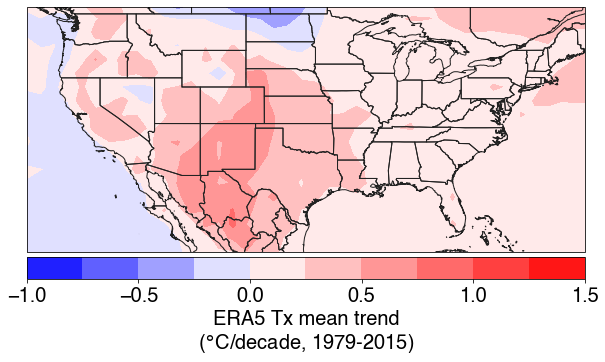

In [19]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 Tx mean trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

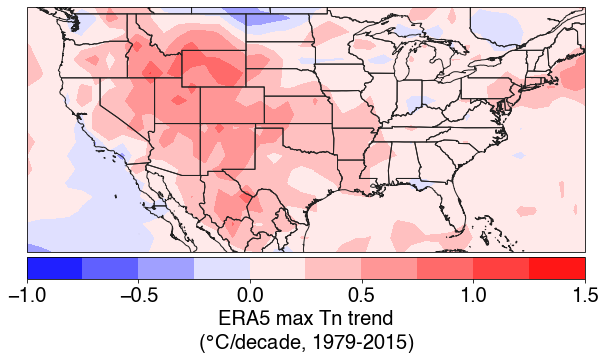

In [20]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_tasmin_max_trend.lon, era5_tasmin_max_trend.lat, era5_tasmin_max_trend.tasmin_max_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 max Tn trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [76]:
%%time
# calculate trend bias between cmip6 and era5

cmip6_era5_tasmax_max_trend_bias_sig = np.full(era5_tasmax_max_trend.tasmax_max_trend.shape, np.nan)
cmip6_era5_tasmax_max_trend_bias = np.full([len(cmip6_models), era5_tasmax_max_trend.tasmax_max_trend.shape[0], era5_tasmax_max_trend.tasmax_max_trend.shape[1]], np.nan)

for m, model in enumerate(cmip6_models):
    cmip6_era5_tasmax_max_trend_bias[m,:,:] = cmip6_tasmax_max_trend.tasmax_max_trend.values[m,:,:] - era5_tasmax_max_trend.tasmax_max_trend.values

for xlat in range(cmip6_era5_tasmax_max_trend_bias_sig.shape[0]):
    for ylon in range(cmip6_era5_tasmax_max_trend_bias_sig.shape[1]):
        t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_max_trend_bias[:, xlat, ylon], 0)
        cmip6_era5_tasmax_max_trend_bias_sig[xlat, ylon] = p

        
cmip6_era5_tasmax_mean_trend_bias_sig = np.full(era5_tasmax_mean_trend.tasmax_mean_trend.shape, np.nan)
cmip6_era5_tasmax_mean_trend_bias = np.full([len(cmip6_models), era5_tasmax_mean_trend.tasmax_mean_trend.shape[0], era5_tasmax_mean_trend.tasmax_mean_trend.shape[1]], np.nan)

for m, model in enumerate(cmip6_models):
    cmip6_era5_tasmax_mean_trend_bias[m,:,:] = cmip6_tasmax_mean_trend.tasmax_mean_trend.values[m,:,:] - era5_tasmax_mean_trend.tasmax_mean_trend.values

for xlat in range(cmip6_era5_tasmax_mean_trend_bias_sig.shape[0]):
    for ylon in range(cmip6_era5_tasmax_mean_trend_bias_sig.shape[1]):
        t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_mean_trend_bias[:, xlat, ylon], 0)
        cmip6_era5_tasmax_mean_trend_bias_sig[xlat, ylon] = p

CPU times: user 16.4 s, sys: 7.55 ms, total: 16.4 s
Wall time: 16.5 s


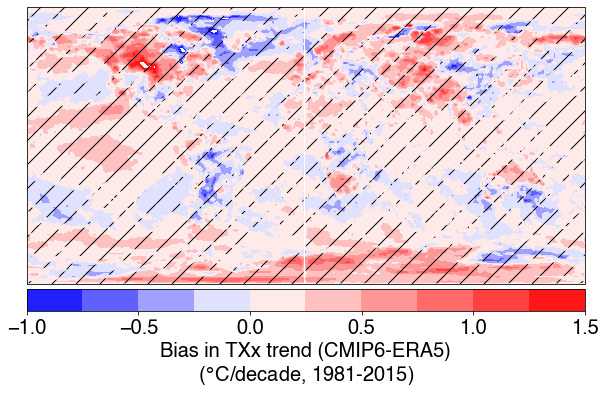

In [77]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, np.nanmedian(cmip6_era5_tasmax_max_trend_bias, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, cmip6_era5_tasmax_max_trend_bias_sig, levels=[0, 0.05], colors='none', hatches=['/', ''])
# ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Bias in TXx trend (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

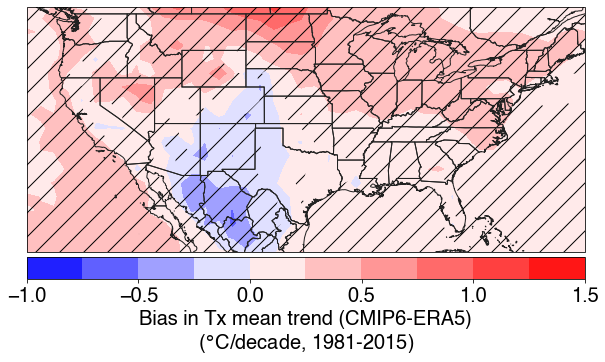

In [23]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, np.nanmedian(cmip6_era5_tasmax_mean_trend_bias, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, cmip6_era5_tasmax_mean_trend_bias_sig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Bias in Tx mean trend (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [124]:
%%time

# calc bias by year
recalc = False
if os.path.isfile('yearly-cmip6-era5-tasmax-max-bias-%s.dat'%region) and not recalc:
    print('loading yearly bias')
    with open('yearly-cmip6-era5-tasmax-max-bias-%s.dat'%region, 'rb') as f:
        yearly_tasmax_max_bias = pickle.load(f)
    with open('yearly-cmip6-era5-tasmax-mean-bias-%s.dat'%region, 'rb') as f:
        yearly_tasmax_mean_bias = pickle.load(f)
else:
    yearly_tasmax_max_bias = np.full([len(cmip6_models), era5_tasmax_max_regrid.time.values.shape[0], \
                                      era5_tasmax_max_regrid.lat.values.shape[0], \
                                      era5_tasmax_max_regrid.lon.values.shape[0]], np.nan)
    yearly_tasmax_mean_bias = np.full([len(cmip6_models), era5_tasmax_mean_regrid.time.values.shape[0], \
                                       era5_tasmax_mean_regrid.lat.values.shape[0], \
                                       era5_tasmax_mean_regrid.lon.values.shape[0]], np.nan)

    for m, model in enumerate(cmip6_models):
        print('processing %s...'%model)
        for y, year in enumerate(range(1981, 2014+1)):
            for xlat in range(yearly_tasmax_max_bias.shape[2]):
                for ylon in range(yearly_tasmax_max_bias.shape[3]):
                    yearly_tasmax_max_bias[m, y, xlat, ylon] = cmip6_tasmax_max_us.tasmax_max.values[m, y, xlat, ylon] - \
                                                                era5_tasmax_max_regrid.tasmax_max.values[y, xlat, ylon]
                    yearly_tasmax_mean_bias[m, y, xlat, ylon] = cmip6_tasmax_mean_us.tasmax_mean.values[m, y, xlat, ylon] - \
                                                                era5_tasmax_mean_regrid.tasmax_mean.values[y, xlat, ylon]
    
    with open('yearly-cmip6-era5-tasmax-max-bias-%s.dat'%region, 'wb') as f:
        pickle.dump(yearly_tasmax_max_bias, f)
    with open('yearly-cmip6-era5-tasmax-mean-bias-%s.dat'%region, 'wb') as f:
        pickle.dump(yearly_tasmax_mean_bias, f)

loading yearly bias
CPU times: user 93.4 ms, sys: 580 ms, total: 673 ms
Wall time: 2.04 s


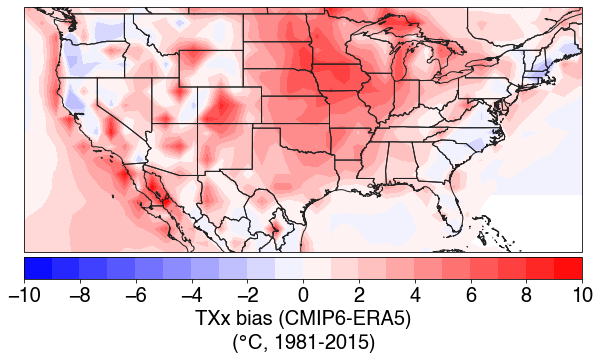

In [125]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -10
v2 = 10.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
                 np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, yearly_txx_bias_trend_sig, levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('TXx bias (CMIP6-ERA5)\n($\degree$C, 1981-2015)', fontsize=20)

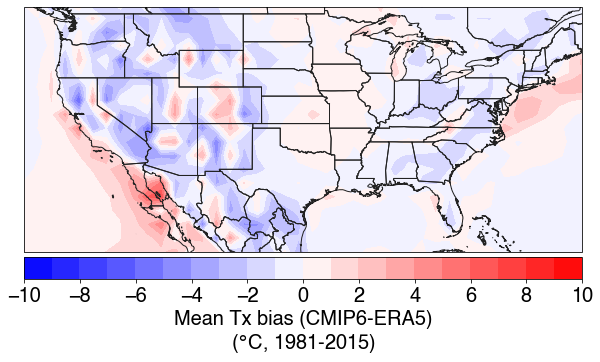

In [26]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -10
v2 = 10.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
                 np.nanmedian(np.nanmean(yearly_tasmax_mean_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, yearly_txx_bias_trend_sig, levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean Tx bias (CMIP6-ERA5)\n($\degree$C, 1981-2015)', fontsize=20)

In [123]:
recalc = False
if os.path.isfile('yearly-cmip6-era5-tasmax-bias-trend-%s.dat'%region) and not recalc:
    print('loading precomputed bias trend...')
    with open('yearly-cmip6-era5-tasmax-bias-trend-%s.dat'%region, 'rb') as f:
        f = pickle.load(f)
        yearly_tasmax_max_bias_trend = f['yearly_tasmax_max_bias_trend']
        yearly_tasmax_max_bias_trend_sig = f['yearly_tasmax_max_bias_trend_sig']
        yearly_tasmax_mean_bias_trend = f['yearly_tasmax_mean_bias_trend']
        yearly_tasmax_mean_bias_trend_sig = f['yearly_tasmax_mean_bias_trend_sig']

else:
    yearly_tasmax_max_bias_trend = np.full([len(cmip6_models), yearly_tasmax_max_bias.shape[2], yearly_tasmax_max_bias.shape[3]], np.nan)
    yearly_tasmax_max_bias_trend_sig = np.full([len(cmip6_models), yearly_tasmax_max_bias.shape[2], yearly_tasmax_max_bias.shape[3]], np.nan)

    yearly_tasmax_mean_bias_trend = np.full([len(cmip6_models), yearly_tasmax_mean_bias.shape[2], yearly_tasmax_mean_bias.shape[3]], np.nan)
    yearly_tasmax_mean_bias_trend_sig = np.full([len(cmip6_models), yearly_tasmax_mean_bias.shape[2], yearly_tasmax_mean_bias.shape[3]], np.nan)

    for m in range(len(cmip6_models_tasmax)):
        print('processing %s...'%cmip6_models_tasmax[m])
        for xlat in range(yearly_tasmax_max_bias_trend.shape[1]):
            for ylon in range(yearly_tasmax_max_bias_trend.shape[2]):
                curBias = np.squeeze(yearly_tasmax_max_bias[m, :, xlat, ylon])
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.RLM(curBias, X).fit()
                yearly_tasmax_max_bias_trend[m, xlat, ylon] = mdl.params[1]*10
                yearly_tasmax_max_bias_trend_sig[m, xlat, ylon] = mdl.pvalues[1]

                curBias = np.squeeze(yearly_tasmax_mean_bias[m, :, xlat, ylon])
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.RLM(curBias, X).fit()
                yearly_tasmax_mean_bias_trend[m, xlat, ylon] = mdl.params[1]*10
                yearly_tasmax_mean_bias_trend_sig[m, xlat, ylon] = mdl.pvalues[1]

    with open('yearly-cmip6-era5-tasmax-bias-trend-%s.dat'%region, 'wb') as f:
        pickle.dump({'yearly_tasmax_max_bias_trend': yearly_tasmax_max_bias_trend,
                     'yearly_tasmax_max_bias_trend_sig':yearly_tasmax_max_bias_trend_sig,
                     'yearly_tasmax_mean_bias_trend':yearly_tasmax_mean_bias_trend,
                     'yearly_tasmax_mean_bias_trend_sig':yearly_tasmax_mean_bias_trend_sig}, f)

loading precomputed bias trend...


In [100]:
era5_tasmax_max_trend.lon

<xarray.DataArray 'lon' (lon: 240)>
array([  0. ,   1.5,   3. , ..., 355.5, 357. , 358.5])
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

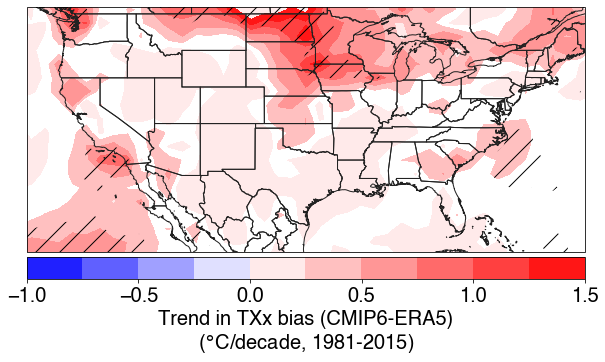

In [121]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
                 np.nanmedian(yearly_tasmax_max_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
             np.nanmedian(yearly_tasmax_max_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in TXx bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

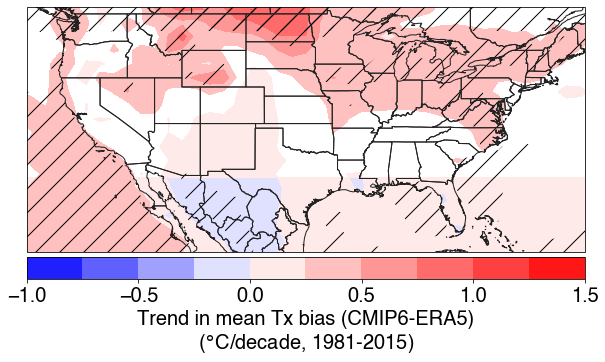

In [122]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
                 np.nanmedian(yearly_tasmax_mean_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
             np.nanmedian(yearly_tasmax_mean_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in mean Tx bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [84]:
# load cropped area data

ca_year = 2005

with open('cropped_area/maize_hw_%d_regrid.dat'%ca_year, 'rb') as f:
    maize_ha_regrid_era5 = pickle.load(f)
    
with open('cropped_area/soy_hw_%d_regrid.dat'%ca_year, 'rb') as f:
    soy_ha_regrid_era5 = pickle.load(f)

with open('cropped_area/wheat_hw_%d_regrid.dat'%ca_year, 'rb') as f:
    wheat_ha_regrid_era5 = pickle.load(f)

regridder = xe.Regridder(xr.DataArray(data=maize_ha_regrid_era5, dims=['lat', 'lon'], coords={'lat':era5_lat, 'lon':era5_lon}), regridMesh_us, 'bilinear')
regridder.clean_weight_file()
maize_ha_regrid_15_us = regridder(maize_ha_regrid_era5)

regridder = xe.Regridder(xr.DataArray(data=soy_ha_regrid_era5, dims=['lat', 'lon'], coords={'lat':era5_lat, 'lon':era5_lon}), regridMesh_us, 'bilinear')
regridder.clean_weight_file()
soy_ha_regrid_15_us = regridder(soy_ha_regrid_era5)

regridder = xe.Regridder(xr.DataArray(data=wheat_ha_regrid_era5, dims=['lat', 'lon'], coords={'lat':era5_lat, 'lon':era5_lon}), regridMesh_us, 'bilinear')
regridder.clean_weight_file()
wheat_ha_regrid_15_us = regridder(wheat_ha_regrid_era5)

Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc


In [46]:
crop_ha_regrid_15_us = np.full(maize_ha_regrid_15_us.shape, np.nan)

In [49]:
for xlat in range(crop_ha_regrid_15_us.shape[0]):
    for ylon in range(crop_ha_regrid_15_us.shape[1]):
        tmp = np.nansum([maize_ha_regrid_15_us[xlat, ylon], soy_ha_regrid_15_us[xlat, ylon], wheat_ha_regrid_15_us[xlat, ylon]])
        if tmp > 0:
            crop_ha_regrid_15_us[xlat, ylon] = tmp


In [42]:
crop_ha_regrid_15_us_1d = np.reshape(crop_ha_regrid_15_us, [crop_ha_regrid_15_us.size,1])

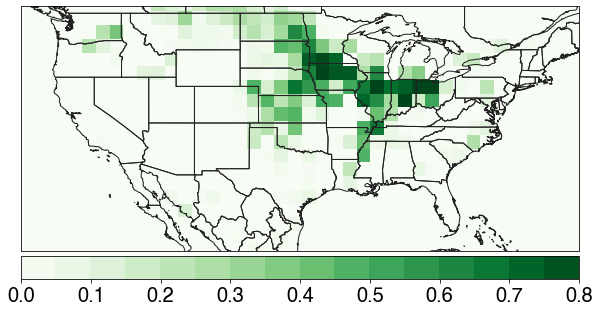

In [50]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = 0
v2 = .81
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, crop_ha_regrid_15_us, cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
# cb.set_label('Trend in T50p bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [324]:
# load deepak data

if not os.path.isfile('deepak_maize.nc'):
    maize_yield_deepak_ds = xr.Dataset()
    for y, year in enumerate(range(1979, 2013+1)):
        print('processing deepak for %d...'%year)
        cur_maize_yield_deepak_ds = xr.open_dataset('%s/Maize_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_maize_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_maize_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_maize_yield_deepak_ds['latitude'].values
        cur_maize_yield_deepak_ds['latitude'] = latvals

        cur_maize_yield_deepak_ds = cur_maize_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_maize_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_maize_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_maize_yield_deepak_ds_regrid = regridder(cur_maize_yield_deepak_ds.Data)

        tempDs_maize_yield = xr.Dataset()
        tempDs_maize_yield['maize_yield'] = xr.DataArray(data = np.squeeze(cur_maize_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            maize_yield_deepak_ds = tempDs_maize_yield
        else:
            maize_yield_deepak_ds = xr.concat([maize_yield_deepak_ds, tempDs_maize_yield], dim='time')
    maize_yield_deepak_ds.to_netcdf('deepak_maize.nc')
else:
    maize_yield_deepak_ds = xr.open_dataset('deepak_maize.nc')

In [292]:
maize_yield_deepak_trend = np.full([maize_yield_deepak_ds.lat.values.size, maize_yield_deepak_ds.lon.values.size], np.nan)

for xlat in range(maize_yield_deepak_trend.shape[0]):
    for ylon in range(maize_yield_deepak_trend.shape[1]):
        curY = maize_yield_deepak_ds.maize_yield.values[:, xlat, ylon]
        nn = np.where((~np.isnan(curY)))[0]
        if len(nn) > 20:
            X = sm.add_constant(range(len(nn)))
            mdl = sm.OLS(curY[nn], X).fit()
            maize_yield_deepak_trend[xlat, ylon] = mdl.params[1]


In [51]:
yearly_tasmax_max_bias_trend_mean = np.nanmean(yearly_tasmax_max_bias_trend, axis=0)
yearly_tasmax_max_bias_mean = np.nanmean(np.nanmean(yearly_tasmax_max_bias, axis=0), axis=0)

Text(0, 0.5, 'CMIP6-ERA5 mean TXx bias')

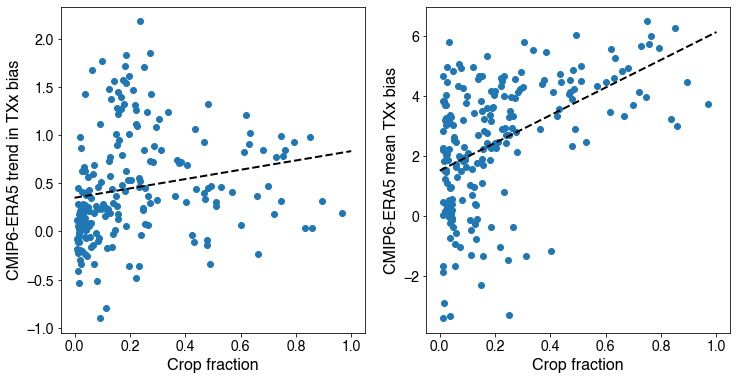

In [53]:
# maize_yield_1d = maize_yield.reshape([maize_yield.size, 1])
# maize_yield_deepak_trend_1d = maize_yield_deepak_trend.reshape([maize_yield_deepak_trend.size, 1])

yearly_tasmax_max_bias_trend_mean_1d = yearly_tasmax_max_bias_trend_mean.reshape([yearly_tasmax_max_bias_trend_mean.size, 1])
yearly_tasmax_max_bias_mean_1d = yearly_tasmax_max_bias_mean.reshape([yearly_tasmax_max_bias_mean.size, 1])

nn_tasmax_max = np.where((~np.isnan(crop_ha_regrid_15_us_1d)) & (~np.isnan(yearly_tasmax_max_bias_trend_mean_1d)) & (crop_ha_regrid_15_us_1d>.01))[0]

X = sm.add_constant(crop_ha_regrid_15_us_1d[nn_tasmax_max])
mdl_tasmax_max_bias_trend = sm.OLS(yearly_tasmax_max_bias_trend_mean_1d[nn_tasmax_max], X).fit()

X = sm.add_constant(crop_ha_regrid_15_us_1d[nn_tasmax_max])
mdl_tasmax_max_bias_mean = sm.OLS(yearly_tasmax_max_bias_mean_1d[nn_tasmax_max], X).fit()

fig, ax = plt.subplots(1,2,figsize=(12,6))

x1 = 0
x2 = 1
ax[0].scatter(crop_ha_regrid_15_us_1d[nn_tasmax_max], yearly_tasmax_max_bias_trend_mean_1d[nn_tasmax_max])
ax[0].plot([x1, x2], [mdl_tasmax_max_bias_trend.params[0]+x1*mdl_tasmax_max_bias_trend.params[1], \
                    mdl_tasmax_max_bias_trend.params[0]+x2*mdl_tasmax_max_bias_trend.params[1]], '--k', lw=2)
ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('CMIP6-ERA5 trend in TXx bias')

x1 = 0
x2 = 1
ax[1].scatter(crop_ha_regrid_15_us_1d[nn_tasmax_max], yearly_tasmax_max_bias_mean_1d[nn_tasmax_max])
ax[1].plot([x1, x2], [mdl_tasmax_max_bias_mean.params[0]+x1*mdl_tasmax_max_bias_mean.params[1], \
                    mdl_tasmax_max_bias_mean.params[0]+x2*mdl_tasmax_max_bias_mean.params[1]], '--k', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].set_ylabel('CMIP6-ERA5 mean TXx bias')

In [55]:
mdl_tasmax_max_bias_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     7.605
Date:                Tue, 30 Mar 2021   Prob (F-statistic):            0.00635
Time:                        10:48:49   Log-Likelihood:                -169.24
No. Observations:                 204   AIC:                             342.5
Df Residuals:                     202   BIC:                             349.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3495      0.055      6.377      0.000       0.241       0.458
x1             0.4842      0.176      2.758      0.006       0.138       0.830
==============================================================================
Omnibus:                       14.343   Durbin-Watson:                   0.308
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.554
Skew:                           0.671   Prob(JB):                     0.000419
Kurtosis:                       3.167   Cond. No.                         4.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [391]:
yearly_txx_bias.shape

(21, 34, 24, 54)

In [392]:
yearly_txx_bias_mean = np.nanmean(yearly_txx_bias, axis=1)
yearly_t50p_bias_mean = np.nanmean(yearly_t50p_bias, axis=1)

In [395]:
for m in range(len(cmip6_models)):
    yearly_txx_bias_mean_1d = np.reshape(yearly_txx_bias_mean[m,:,:], [yearly_txx_bias_mean[m,:,:].size, 1])
    yearly_t50p_bias_mean_1d = np.reshape(yearly_t50p_bias_mean[m,:,:], [yearly_t50p_bias_mean[m,:,:].size, 1])
    
    nn = np.where((~np.isnan(maize_ha_regrid_15_us_1d)) & (~np.isnan(yearly_txx_bias_mean_1d)))[0]
    
    X = sm.add_constant(maize_ha_regrid_15_us_1d[nn])
    mdl = sm.RLM(yearly_txx_bias_mean_1d[nn], X).fit()
    
    print('%.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
    

8.43, p = 0.00
14.97, p = 0.00
11.46, p = 0.00
17.66, p = 0.00
16.62, p = 0.00
11.65, p = 0.00
0.72, p = 0.46
0.31, p = 0.77
2.25, p = 0.08
-0.03, p = 0.98
18.54, p = 0.00
10.88, p = 0.00
21.04, p = 0.00
11.14, p = 0.00
5.59, p = 0.00
4.61, p = 0.00
4.05, p = 0.00
4.55, p = 0.00
12.11, p = 0.00
14.06, p = 0.00
12.71, p = 0.00


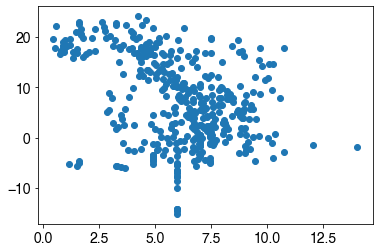

In [160]:
m = 5
yearly_t50p_bias_mean_1d = np.reshape(yearly_t50p_bias_mean[:,:,m], [yearly_t50p_bias_mean[:,:,m].size, 1])
nn = np.where((~np.isnan(maize_yield_1d)) & (~np.isnan(yearly_t50p_bias_mean_1d)))[0]
plt.scatter(maize_yield_1d[nn], yearly_t50p_bias_mean_1d[nn])

In [319]:
X = sm.add_constant(maize_yield_1d[nn])
mdl = sm.RLM(yearly_txx_bias_mean_1d[nn], X).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                  417
Model:                            RLM   Df Residuals:                      415
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 25 Mar 2021                                         
Time:                        13:17:07                                         
No. Iterations:                    12                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0754      0.456     -0.165      0.869      -0.969       0.818
x1             0.3460      0.070      4.908      0.000       0.208       0.484
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""